<a href="https://colab.research.google.com/github/karhol/mock-portfolio/blob/main/Fetal_Health_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetal Health Prediction

Dataset:

https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

Data

This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

    Normal
    Suspect
    Pathological


Import Library

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings(action='ignore')

In [223]:
data = pd.read_csv('fetal_health.csv')
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [ ]:
data.info()
#data.describe()
#data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

Heatmap Correlation Matrix

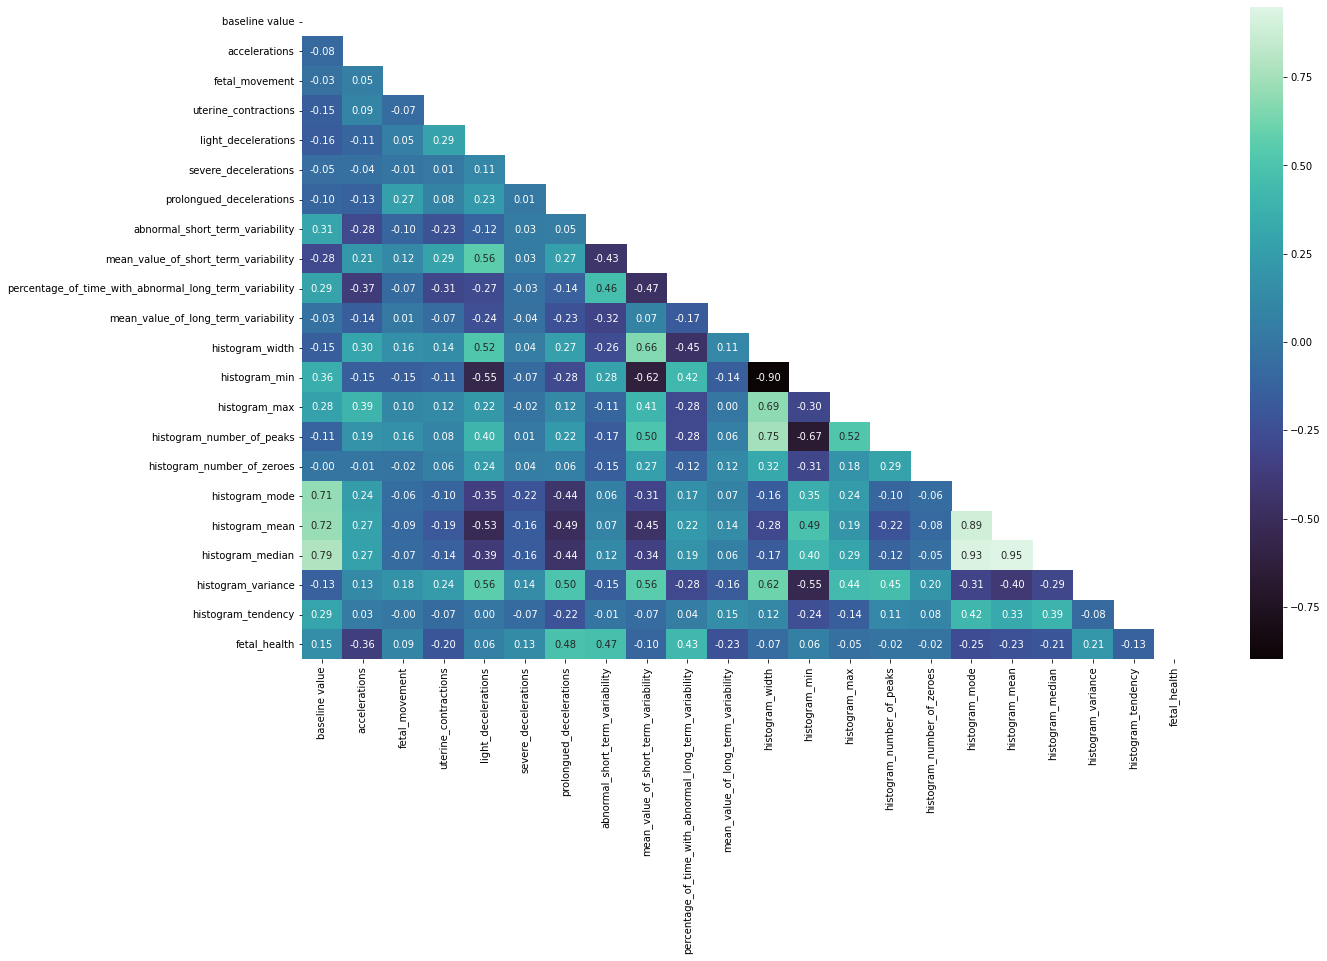

In [ ]:
# heatmap 

plt.figure(figsize = (20, 12))

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, cmap="mako", annot = True, fmt = ".2f")
plt.show()

Target 

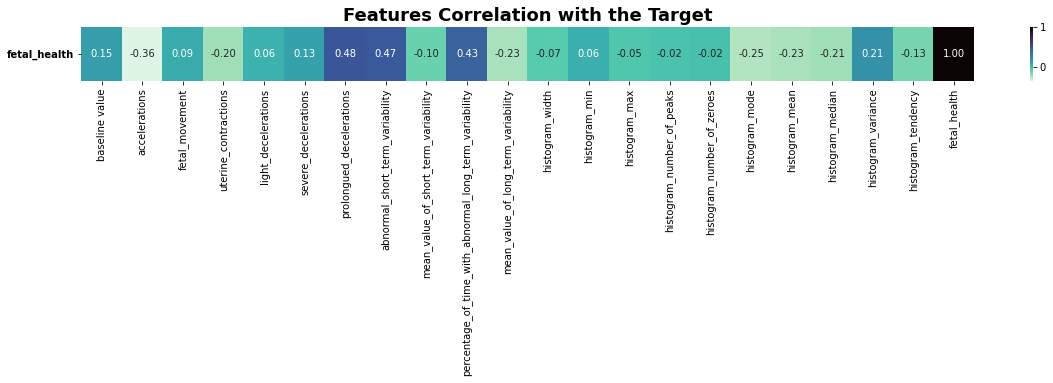

In [ ]:
numeric_data = data.select_dtypes(exclude="object")
numeric_corr = numeric_data.corr()
f,ax=plt.subplots(figsize=(20,1))
sns.heatmap(numeric_corr.sort_values(by=["fetal_health"], ascending=False).head(1), cmap="mako_r",annot = True, fmt = ".2f")
plt.title("Features Correlation with the Target", weight="bold", fontsize=18, color="Black")
plt.yticks(weight="bold", color="black", rotation=0)

plt.show()

The features with highest correlation are

* prolongued_decelerations:                              0.484859

* abnormal_short_term_variability:                          0.471191

* percentage_of_time_with_abnormal_long_term_variability:    0.426146

The features with lowest correlation are 

* histogram_number_of_zeroes:                               -0.016682

* histogram_number_of_peaks:                              -0.023666

* histogram_max:                                            -0.045265

* histogram_width:                                          -0.068789

Pie chart showing the target values

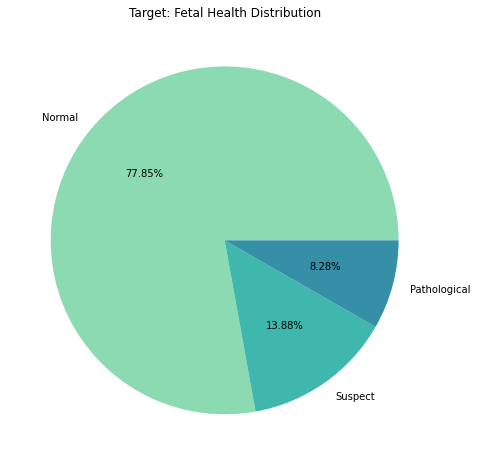

In [ ]:
plt.figure(figsize=(8, 8))

plt.pie(
    data['fetal_health'].value_counts(),
    autopct='%.2f%%',
    labels=["Normal", "Suspect", "Pathological"],
    colors=sns.color_palette('mako_r')
)

plt.title("Target: Fetal Health Distribution")
plt.show()

The target label is highly imbalanced, almost all of it is the "Normal" value

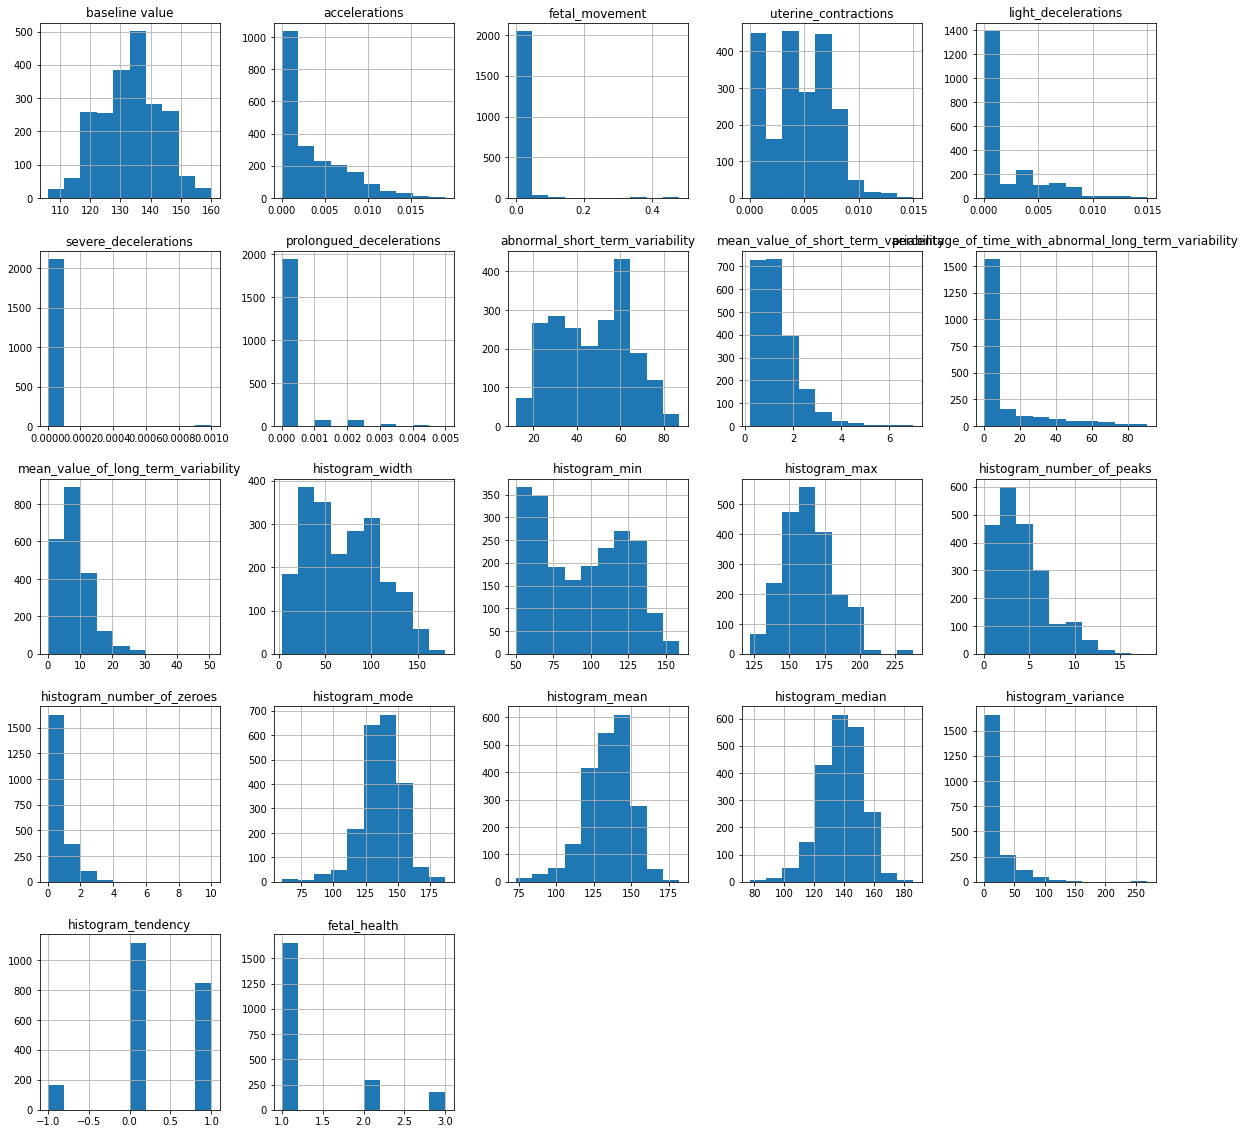

In [ ]:
# Evaluating distributions of the features 
hist_plot = data.hist(figsize = (20,20), color = "#1f77b4")

All the attributes more or less are midly skewed and are normally distributed except the features "light_decelerations", "precentage_of_time_with_abnormal_long_term_variability" etc.

Preprocessing

In [224]:
def preprocessing(df):
    df = df.copy()
    
    # Make target values numerical
    df['fetal_health'] = df['fetal_health'].replace({1.0: "NORMAL",2.0: "SUSPECT",3.0: "PATHOLOGICAL"})
    
    # Split df into X and y
    y = df['fetal_health']
    X = df.drop('fetal_health', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [225]:
X_train, X_test, y_train, y_test = preprocessing(data)

In [226]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "                              LightGBM": LGBMClassifier(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                              LightGBM trained.


In [227]:
results = []
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))
    results.append(model.score(X_test, y_test) * 100)

                   Logistic Regression: 90.13%
                   K-Nearest Neighbors: 89.97%
                         Decision Tree: 91.38%
Support Vector Machine (Linear Kernel): 89.03%
   Support Vector Machine (RBF Kernel): 91.07%
                        Neural Network: 91.69%
                         Random Forest: 92.79%
                     Gradient Boosting: 94.98%
                               XGBoost: 94.83%
                              LightGBM: 94.83%


In [228]:
models1 = [item.strip() for item in list(models.keys())]

model_results = pd.DataFrame(
    {'Model': models1,
     'Test_score': results,
    })

display(model_results.style.background_gradient(cmap='mako_r'))

,Model,Test_score
0,Logistic Regression,90.125392
1,K-Nearest Neighbors,89.968652
2,Decision Tree,91.379310
3,Support Vector Machine (Linear Kernel),89.028213
4,Support Vector Machine (RBF Kernel),91.065831
5,Neural Network,91.692790
6,Random Forest,92.789969
7,Gradient Boosting,94.984326
8,XGBoost,94.827586
9,LightGBM,94.827586


the top models are 
* Gradient Boosting trained.
* XGBoost trained.
* LightGBM trained.

it might be nice to try out gridSearchCV on the top models until we have one that wins

Refrences:

https://www.kaggle.com/code/asimislam/python-colors-color-cmap-palette

https://www.kaggle.com/code/pariaagharabi/step-by-step-fetal-health-prediction-99-detailed

https://www.kaggle.com/code/vivovinco/ultimate-cheatsheets-data-visualization

https://www.kaggle.com/code/landfallmotto/fetal-health-data-profile-boruta-model-stacking